# 3D Visualizations

The visualizations in this notebook will be used in the written form submission of this project.

In [1]:
import pickle
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
import plotly.io as pio
pio.templates.default = "plotly"

In [13]:
def move_to_origin(pc):
    mean = np.mean(pc, axis=0)
    return pc - mean

In [3]:
with open(f"point_clouds/proteins.pkl", "rb") as f:
    proteins = pickle.load(f)

In [14]:
protein = proteins['objects'][0]
protein = move_to_origin(protein)

In [5]:
mcgill = np.load(f"point_clouds/mc_gill_whole.npz", allow_pickle=True)

In [15]:
table = mcgill['objects'][0]
table = move_to_origin(table)

## Object Silhouette Visualization

In [16]:
def create_figure_silhouette_3d(point_cloud, file_name):
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=point_cloud[:, 0],
                y=point_cloud[:, 1],
                z=point_cloud[:, 2],
                name=f"Point Cloud",
                mode='markers',
                marker=dict(
                    size=4,
                    color='#436436',
                    opacity=0.8
                )
            )
        ]
    )

    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,
                showgrid=False,
                backgroundcolor="white"
            ),
            yaxis=dict(
                title='',
                showticklabels=False,
                showgrid=False,
                backgroundcolor="white"
            ),
            zaxis=dict(
                title='',
                showticklabels=False,
                showgrid=False,
                backgroundcolor="white"
            )
        ),
        margin=dict(l=0, r=0, b=0, t=0)
    )

    fig.write_html(f'figures/blog/{file_name}.html')
    fig.show()

In [17]:
create_figure_silhouette_3d(protein, 'protein_silhouette_3d')

In [18]:
create_figure_silhouette_3d(table, 'table_silhouette_3d')


# SIRM Visualization

In [47]:
def create_sirm_visualization(point_cloud, file_name):
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=point_cloud[:, 0],
                y=point_cloud[:, 1],
                z=point_cloud[:, 2],
                name=f"Point Cloud",
                mode='markers',
                marker=dict(
                    size=4,
                    color='#436436',
                    opacity=0.2
                )
            )
        ]
    )

    x_min, x_max = point_cloud[:, 0].min(), point_cloud[:, 0].max()
    y_min, y_max = point_cloud[:, 1].min(), point_cloud[:, 1].max()
    z_min, z_max = point_cloud[:, 2].min(), point_cloud[:, 2].max()

    xy_edges = [
        [x_min, y_min, 0], [x_max, y_min, 0],
        [x_max, y_min, 0], [x_max, y_max, 0],
        [x_max, y_max, 0], [x_min, y_max, 0],
        [x_min, y_max, 0], [x_min, y_min, 0]
    ]

    # XZ Plane edges
    xz_edges = [
        [x_min, 0, z_min], [x_max, 0, z_min],
        [x_max, 0, z_min], [x_max, 0, z_max],
        [x_max, 0, z_max], [x_min, 0, z_max],
        [x_min, 0, z_max], [x_min, 0, z_min]
    ]

    # YZ Plane edges
    yz_edges = [
        [0, y_min, z_min], [0, y_max, z_min],
        [0, y_max, z_min], [0, y_max, z_max],
        [0, y_max, z_max], [0, y_min, z_max],
        [0, y_min, z_max], [0, y_min, z_min]
    ]

    def create_line_trace(edges, color, name):
        edges = list(zip(*edges))  # Transpose to separate x, y, z
        return go.Scatter3d(
            x=edges[0],
            y=edges[1],
            z=edges[2],
            mode='lines',
            line=dict(color=color, width=2),
            name=name,
            legendgroup=name.split()[0]
        )

    fig.add_trace(create_line_trace(xy_edges, '#2F243A', 'XY Plane'))
    fig.add_trace(create_line_trace(xz_edges, '#ffa600', 'XZ Plane'))
    fig.add_trace(create_line_trace(yz_edges, '#9b3d60', 'YZ Plane'))

    def create_2d_hull_projection(fig, point_cloud, projection_axes, fixed_axis, fixed_value, color, name):
        # Project onto the specified 2D subspace
        projected_points = point_cloud[:, projection_axes]
        hull = ConvexHull(projected_points)

        # Add convex hull edges to the plot
        for simplex in hull.simplices:
            # Extract the points on the edge
            edge_points = projected_points[simplex]

            # Create 3D points with the fixed axis
            points_3d = np.zeros((2, 3))  # Two points per edge
            points_3d[:, projection_axes[0]] = edge_points[:, 0]
            points_3d[:, projection_axes[1]] = edge_points[:, 1]
            points_3d[:, fixed_axis] = fixed_value

            # Add to the figure as a 3D line
            fig.add_trace(go.Scatter3d(
                x=points_3d[:, 0],
                y=points_3d[:, 1],
                z=points_3d[:, 2],
                mode='lines',
                line=dict(color=color, width=2),
                name=name,
                legendgroup=name.split()[0],
                showlegend=False
            ))

    create_2d_hull_projection(fig, point_cloud, [0, 1], 2, 0, '#2F243A', 'XY Plane')
    create_2d_hull_projection(fig, point_cloud, [0, 2], 1, 0, '#ffa600', 'XZ Plane')
    create_2d_hull_projection(fig, point_cloud, [1, 2], 0, 0, '#9b3d60', 'YZ Plane')

    fig.update_layout(
        scene=dict(
            xaxis=dict(
                showgrid=False,
                zeroline=True,
                zerolinecolor="black",
                backgroundcolor="white"
            ),
            yaxis=dict(
                showgrid=False,
                zeroline=True,
                zerolinecolor="black",
                backgroundcolor="white"
            ),
            zaxis=dict(
                showgrid=False,
                zeroline=True,
                zerolinecolor="black",
                backgroundcolor="white"
            ),
            camera=dict(
                eye=dict(x=1.25, y=1.25, z=1.25)
            )
        ),
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(
                        label="Default View",
                        method="relayout",
                        args=["scene.camera", dict(eye=dict(x=1.25, y=1.25, z=1.25))]
                    ),
                    dict(
                        label="XY Plane",
                        method="relayout",
                        args=["scene.camera", dict(eye=dict(x=0, y=0, z=2), up=dict(x=1, y=0, z=0))]
                    ),
                    dict(
                        label="XZ Plane",
                        method="relayout",
                        args=["scene.camera", dict(eye=dict(x=0, y=2, z=0))]
                    ),
                    dict(
                        label="YZ Plane",
                        method="relayout",
                        args=["scene.camera", dict(eye=dict(x=2, y=0, z=0))]
                    )
                ],
                direction="left",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            )
        ]
    )

    # Save to HTML and show
    fig.write_html(f"figures/blog/{file_name}_sirm.html")
    fig.show()

In [48]:
create_sirm_visualization(protein, 'protein')

In [49]:
create_sirm_visualization(table, 'table')

# SAMP visualization


In [40]:
def create_samp_visualization(point_cloud, file_name):
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=point_cloud[:, 0],
                y=point_cloud[:, 1],
                z=point_cloud[:, 2],
                name=f"Point Cloud",
                mode='markers',
                marker=dict(
                    size=4,
                    color='#436436',
                    opacity=0.2
                )
            )
        ]
    )

    def add_lines_and_points(fig, point_cloud, plane, name, color, color2):
        segments = np.linspace(np.min(point_cloud[:, plane[0]]), np.max(point_cloud[:, plane[0]]), 10)
        plane_min = np.min(point_cloud[:, plane[1]])
        plane_max = np.max(point_cloud[:, plane[1]])
        first = True
        for idx, segment in enumerate(segments):
            data = {
                plane[0]: [segment, segment],
                plane[1]: [plane_min, plane_max],
                plane[2]: [0, 0]
            }

            fig.add_trace(go.Scatter3d(
                x=data[0],
                y=data[1],
                z=data[2],
                mode='lines',
                line=dict(
                    color=color
                ),
                name=name,
                legendgroup=name.split()[0],
                showlegend=first
            ))
            first = False

            if idx < len(segments) - 1:
                candidate_points = point_cloud[
                    (point_cloud[:, plane[0]] >= segments[idx]) & (point_cloud[:, plane[0]] < segments[idx + 1])
                ]
                sorted_points = candidate_points[candidate_points[:, plane[1]].argsort()]
                top_10 = sorted_points[0:10]
                bottom_10 = sorted_points[-10:]
                plot_points = np.concatenate((top_10, bottom_10))

                plot_points[:, plane[2]] = 0

                fig.add_trace(go.Scatter3d(
                    x=plot_points[:, 0],
                    y=plot_points[:, 1],
                    z=plot_points[:, 2],
                    mode='markers',
                    marker=dict(
                        size=4,
                        color=color if idx % 2 == 0 else color2,
                    ),
                    name=f'{name} Segment {idx}',
                    legendgroup=name.split()[0],
                    showlegend=False
                ))


    for plane in [[0, 1, 2, 'XY Plane', '#2F243A', '#d05057'], [1, 0, 2, 'YX Plane', '#d05057', '#2F243A'],
                  [0, 2, 1, 'XZ Plane', '#613256', '#f4743d'], [2, 0, 1, 'ZX Plane', '#f4743d', '#613256'],
                  [1, 2, 0, 'YZ Plane', '#9b3d60', '#ffa600'], [2, 1, 0, 'ZY Plane', '#ffa600', '#9b3d60']
                  ]:
        name = plane[3]
        color = plane[4]
        color2 = plane[5]
        add_lines_and_points(fig, point_cloud, plane, name, color, color2)

    fig.update_layout(
        scene=dict(
            xaxis=dict(
                showgrid=False,
                zeroline=True,
                zerolinecolor="black",
                backgroundcolor="white"
            ),
            yaxis=dict(
                showgrid=False,
                zeroline=True,
                zerolinecolor="black",
                backgroundcolor="white"
            ),
            zaxis=dict(
                showgrid=False,
                zeroline=True,
                zerolinecolor="black",
                backgroundcolor="white"
            ),
            camera=dict(
                eye=dict(x=1.25, y=1.25, z=1.25)
            )
        ),
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(
                        label="Default View",
                        method="relayout",
                        args=["scene.camera", dict(eye=dict(x=1.25, y=1.25, z=1.25))]
                    ),
                    dict(
                        label="XY/YX Plane",
                        method="relayout",
                        args=["scene.camera", dict(eye=dict(x=0, y=0, z=2), up=dict(x=1, y=0, z=0))]
                    ),
                    dict(
                        label="XZ/ZX Plane",
                        method="relayout",
                        args=["scene.camera", dict(eye=dict(x=0, y=2, z=0))]
                    ),
                    dict(
                        label="YZ/ZY Plane",
                        method="relayout",
                        args=["scene.camera", dict(eye=dict(x=2, y=0, z=0))]
                    )
                ],
                direction="left",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            )
        ]
    )

    # Save to HTML and show
    fig.write_html(f"figures/blog/{file_name}_samp.html")
    fig.show()

In [41]:
create_samp_visualization(protein, 'protein')

In [42]:
create_samp_visualization(table, 'table')

# SCOMP Visualization

In [52]:
def create_scomp_visualization(point_cloud, file_name):
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=point_cloud[:, 0],
                y=point_cloud[:, 1],
                z=point_cloud[:, 2],
                name=f"Point Cloud",
                mode='markers',
                marker=dict(
                    size=4,
                    color='#436436',
                    opacity=0.2
                )
            )
        ]
    )

    def create_grid_projection(fig, point_cloud, segment_axis, projection_axis, fixed_axis, fixed_value, color, name, first=True):
        segments = np.linspace(np.min(point_cloud[:, segment_axis]), np.max(point_cloud[:, segment_axis]), 5)
        plane_min = np.min(point_cloud[:, projection_axis])
        plane_max = np.max(point_cloud[:, projection_axis])
        first = first
        for idx, segment in enumerate(segments):
            data = {
                segment_axis: [segment, segment],
                projection_axis: [plane_min, plane_max],
                fixed_axis: [fixed_value, fixed_value]
            }

            fig.add_trace(go.Scatter3d(
                x=data[0],
                y=data[1],
                z=data[2],
                mode='lines',
                line=dict(
                    color=color
                ),
                name=name,
                legendgroup=name.split()[0],
                showlegend=first
            ))
            first = False

    def create_2d_hull_projection(fig, point_cloud, projection_axes, fixed_axis, fixed_value, color, name):
        # Project onto the specified 2D subspace
        projected_points = point_cloud[:, projection_axes]
        hull = ConvexHull(projected_points)
        for simplex in hull.simplices:
            edge_points = projected_points[simplex]

            points_3d = np.zeros((2, 3))
            points_3d[:, projection_axes[0]] = edge_points[:, 0]
            points_3d[:, projection_axes[1]] = edge_points[:, 1]
            points_3d[:, fixed_axis] = fixed_value

            fig.add_trace(go.Scatter3d(
                x=points_3d[:, 0],
                y=points_3d[:, 1],
                z=points_3d[:, 2],
                mode='lines',
                line=dict(color=color, width=2),
                name=name,
                legendgroup=name.split()[0],
                showlegend=False
            ))

    create_2d_hull_projection(fig, point_cloud, [0, 1], 2, 0, '#2F243A', 'XY Plane')
    create_2d_hull_projection(fig, point_cloud, [0, 2], 1, 0, '#613256', 'XZ Plane')
    create_2d_hull_projection(fig, point_cloud, [1, 2], 0, 0, '#9b3d60', 'YZ Plane')
    create_grid_projection(fig, point_cloud, 0, 1, 2, 0, '#2F243A', 'XY Plane')
    create_grid_projection(fig, point_cloud, 1, 0, 2, 0, '#2F243A', 'XY Plane', False)
    create_grid_projection(fig, point_cloud, 0, 2, 1, 0, '#ffa600', 'XZ Plane')
    create_grid_projection(fig, point_cloud, 2, 0, 1, 0, '#ffa600', 'XZ Plane', False)
    create_grid_projection(fig, point_cloud, 1, 2, 0, 0, '#9b3d60', 'YZ Plane')
    create_grid_projection(fig, point_cloud, 2, 1, 0, 0, '#9b3d60', 'YZ Plane', False)


    fig.update_layout(
        scene=dict(
            xaxis=dict(
                showgrid=False,
                zeroline=True,
                zerolinecolor="black",
                backgroundcolor="white"
            ),
            yaxis=dict(
                showgrid=False,
                zeroline=True,
                zerolinecolor="black",
                backgroundcolor="white"
            ),
            zaxis=dict(
                showgrid=False,
                zeroline=True,
                zerolinecolor="black",
                backgroundcolor="white"
            ),
            camera=dict(
                eye=dict(x=1.25, y=1.25, z=1.25)
            )
        ),
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(
                        label="Default View",
                        method="relayout",
                        args=["scene.camera", dict(eye=dict(x=1.25, y=1.25, z=1.25))]
                    ),
                    dict(
                        label="XY Plane",
                        method="relayout",
                        args=["scene.camera", dict(eye=dict(x=0, y=0, z=2), up=dict(x=1, y=0, z=0))]
                    ),
                    dict(
                        label="XZ Plane",
                        method="relayout",
                        args=["scene.camera", dict(eye=dict(x=0, y=2, z=0))]
                    ),
                    dict(
                        label="YZ Plane",
                        method="relayout",
                        args=["scene.camera", dict(eye=dict(x=2, y=0, z=0))]
                    )
                ],
                direction="left",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            )
        ]
    )

    # Save to HTML and show
    fig.write_html(f"figures/blog/{file_name}_scomp.html")
    fig.show()

In [53]:
create_scomp_visualization(protein, 'protein')

In [54]:
create_scomp_visualization(table, 'table')

# Mutual/Symmetric Toy Example

In [112]:
import networkx as nx
import matplotlib.pyplot as plt

In [113]:
G = np.array([
    [0, 0, 1, 0, 1], 
    [0, 0, 1, 0, 1], 
    [1, 0, 0, 1, 0], 
    [0, 0, 1, 0, 1], 
    [1, 1, 0, 0, 0]
])
directed = nx.from_numpy_array(G, create_using=nx.DiGraph)
pos = nx.circular_layout(directed)


In [114]:
def draw_graph(graph, pos, title):
    plt.figure(figsize=(10, 8), dpi=300)
    plt.axis('off')

    node_size = 3000
    nx.draw_networkx_nodes(graph, pos, node_color=['#9b3d60'], node_size=node_size)
    nx.draw_networkx_edges(graph, pos, arrows=True, width=3, arrowsize=30, node_size=node_size-400)

    plt.savefig(f'figures/blog/{title.replace(" ", "_").lower().replace("-", "")}_knn_visualization.png')

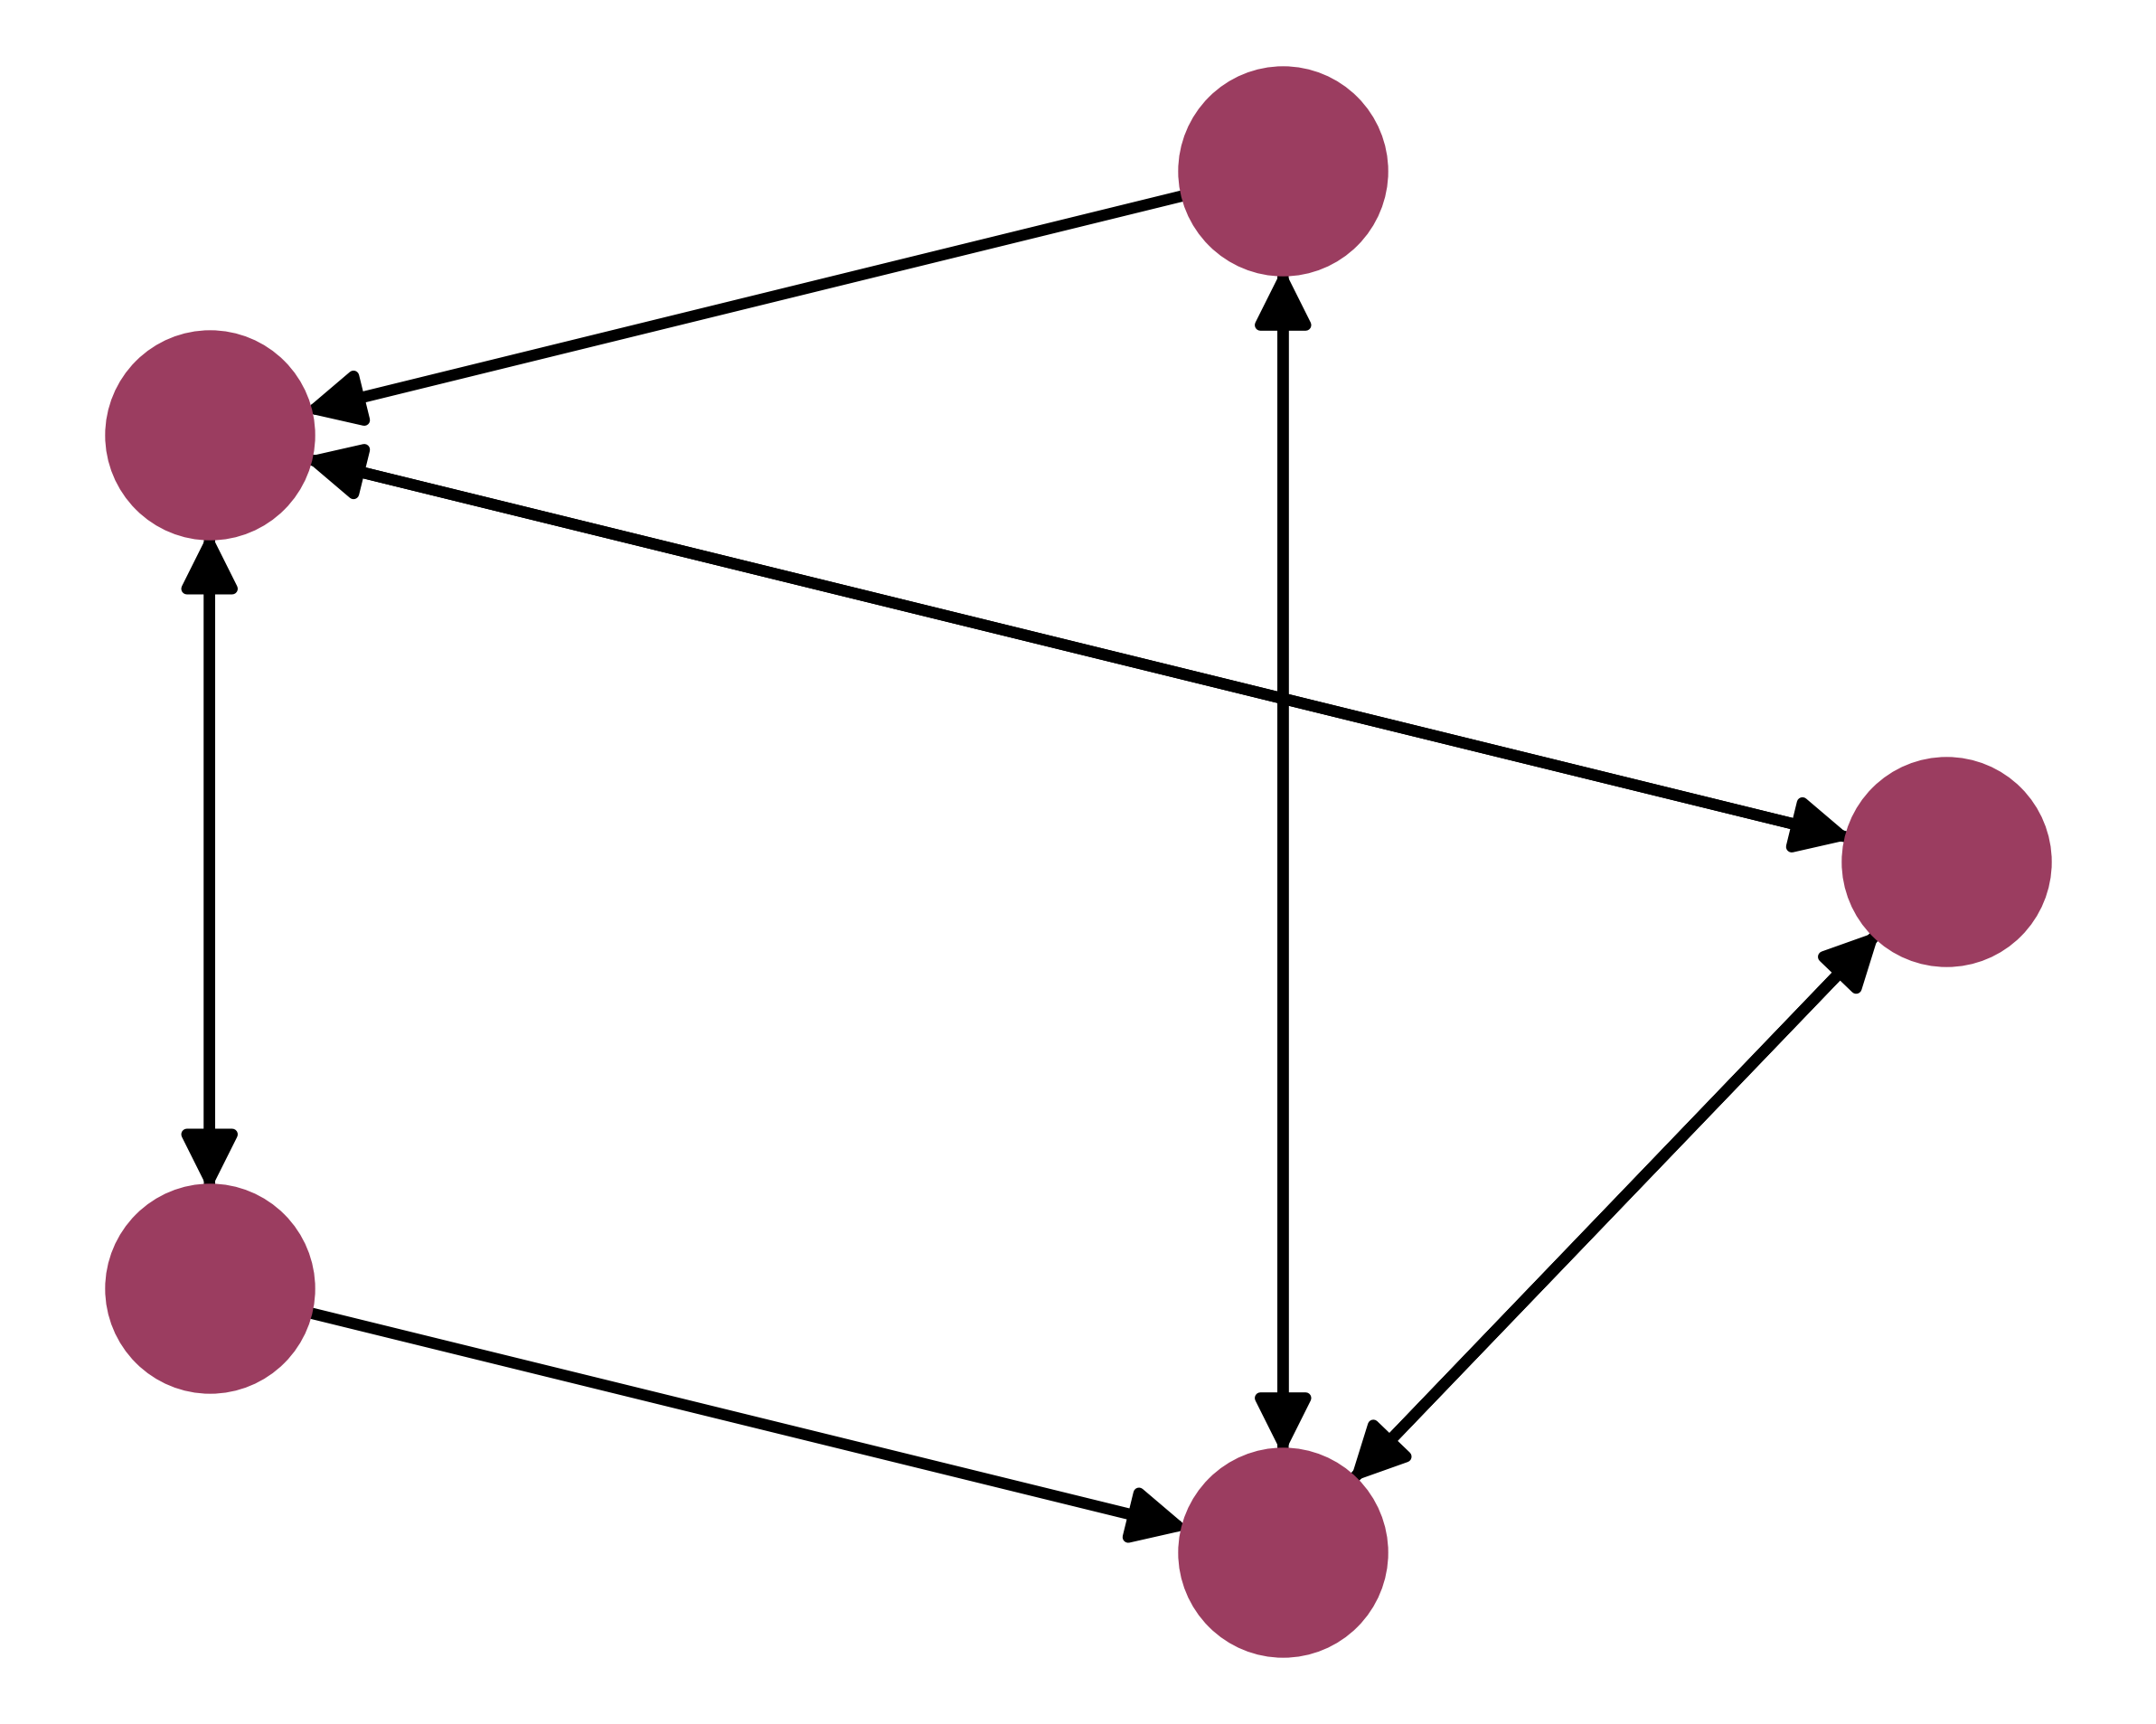

In [115]:
draw_graph(directed, pos, 'Directed k-NN Graph')

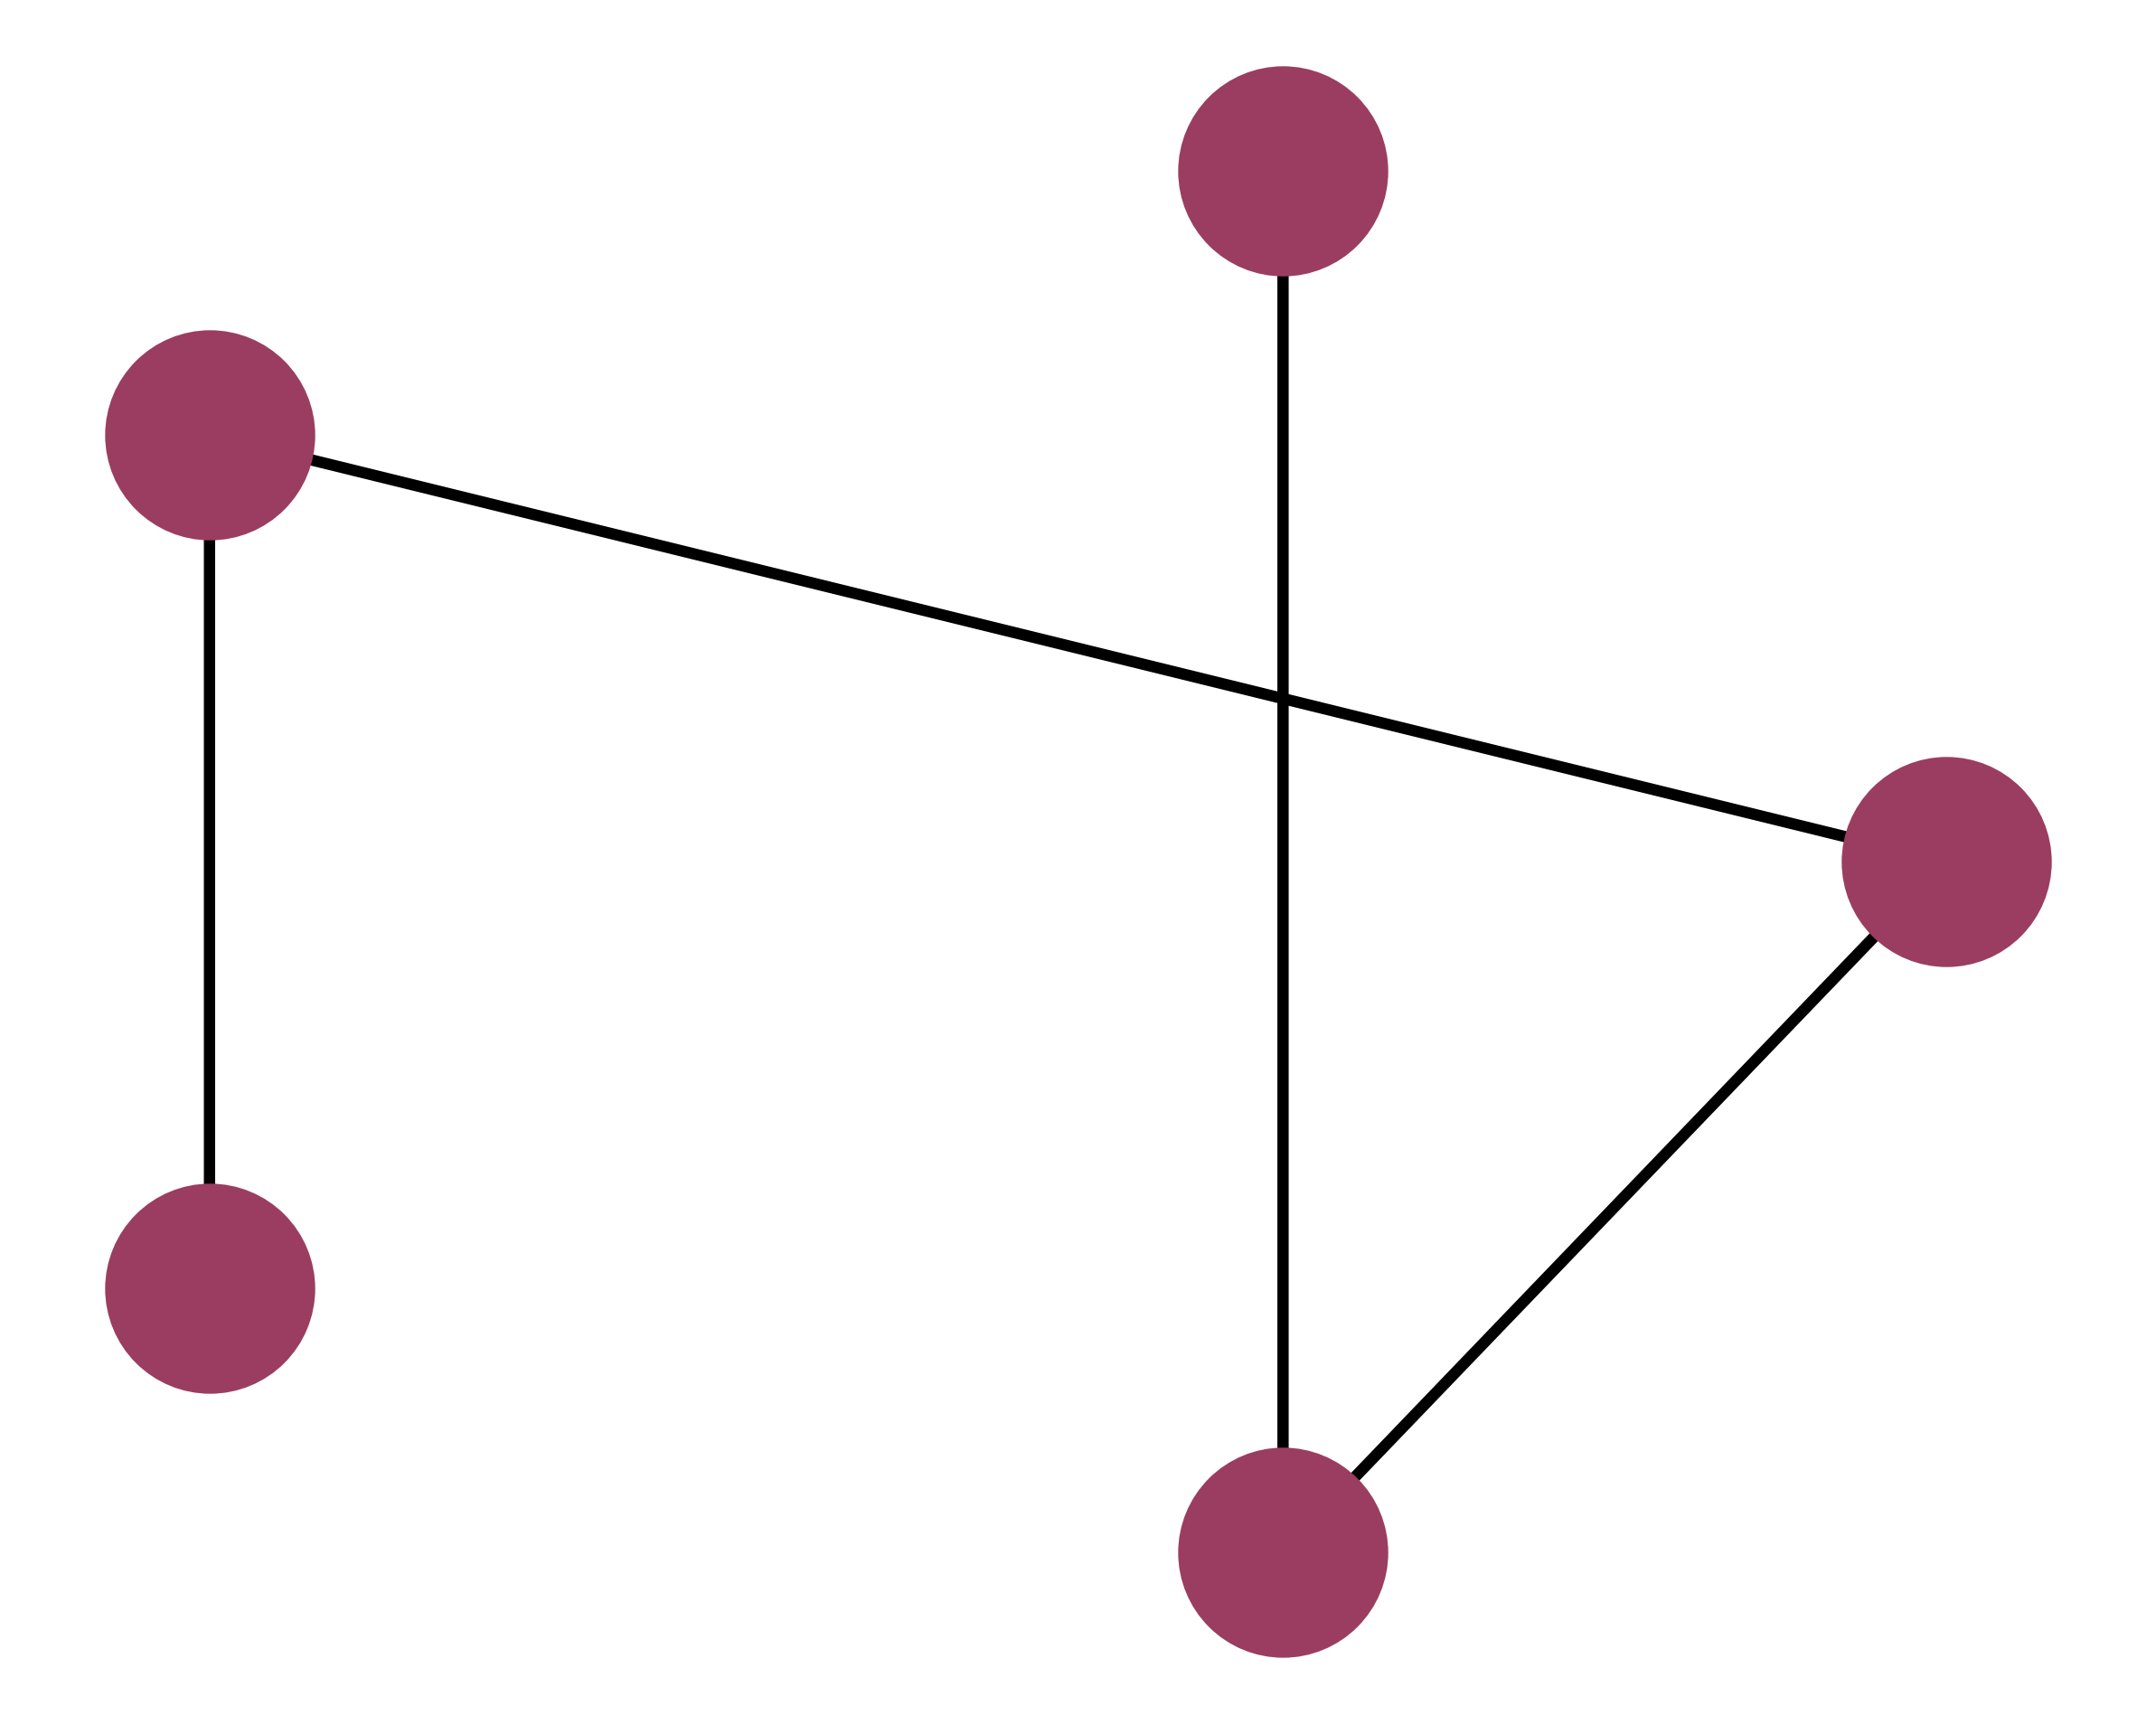

In [119]:
mutual = np.minimum(G, G.transpose())
mutual = nx.from_numpy_array(mutual, create_using=nx.Graph)
draw_graph(mutual, pos, 'Mutual k-NN Graph')

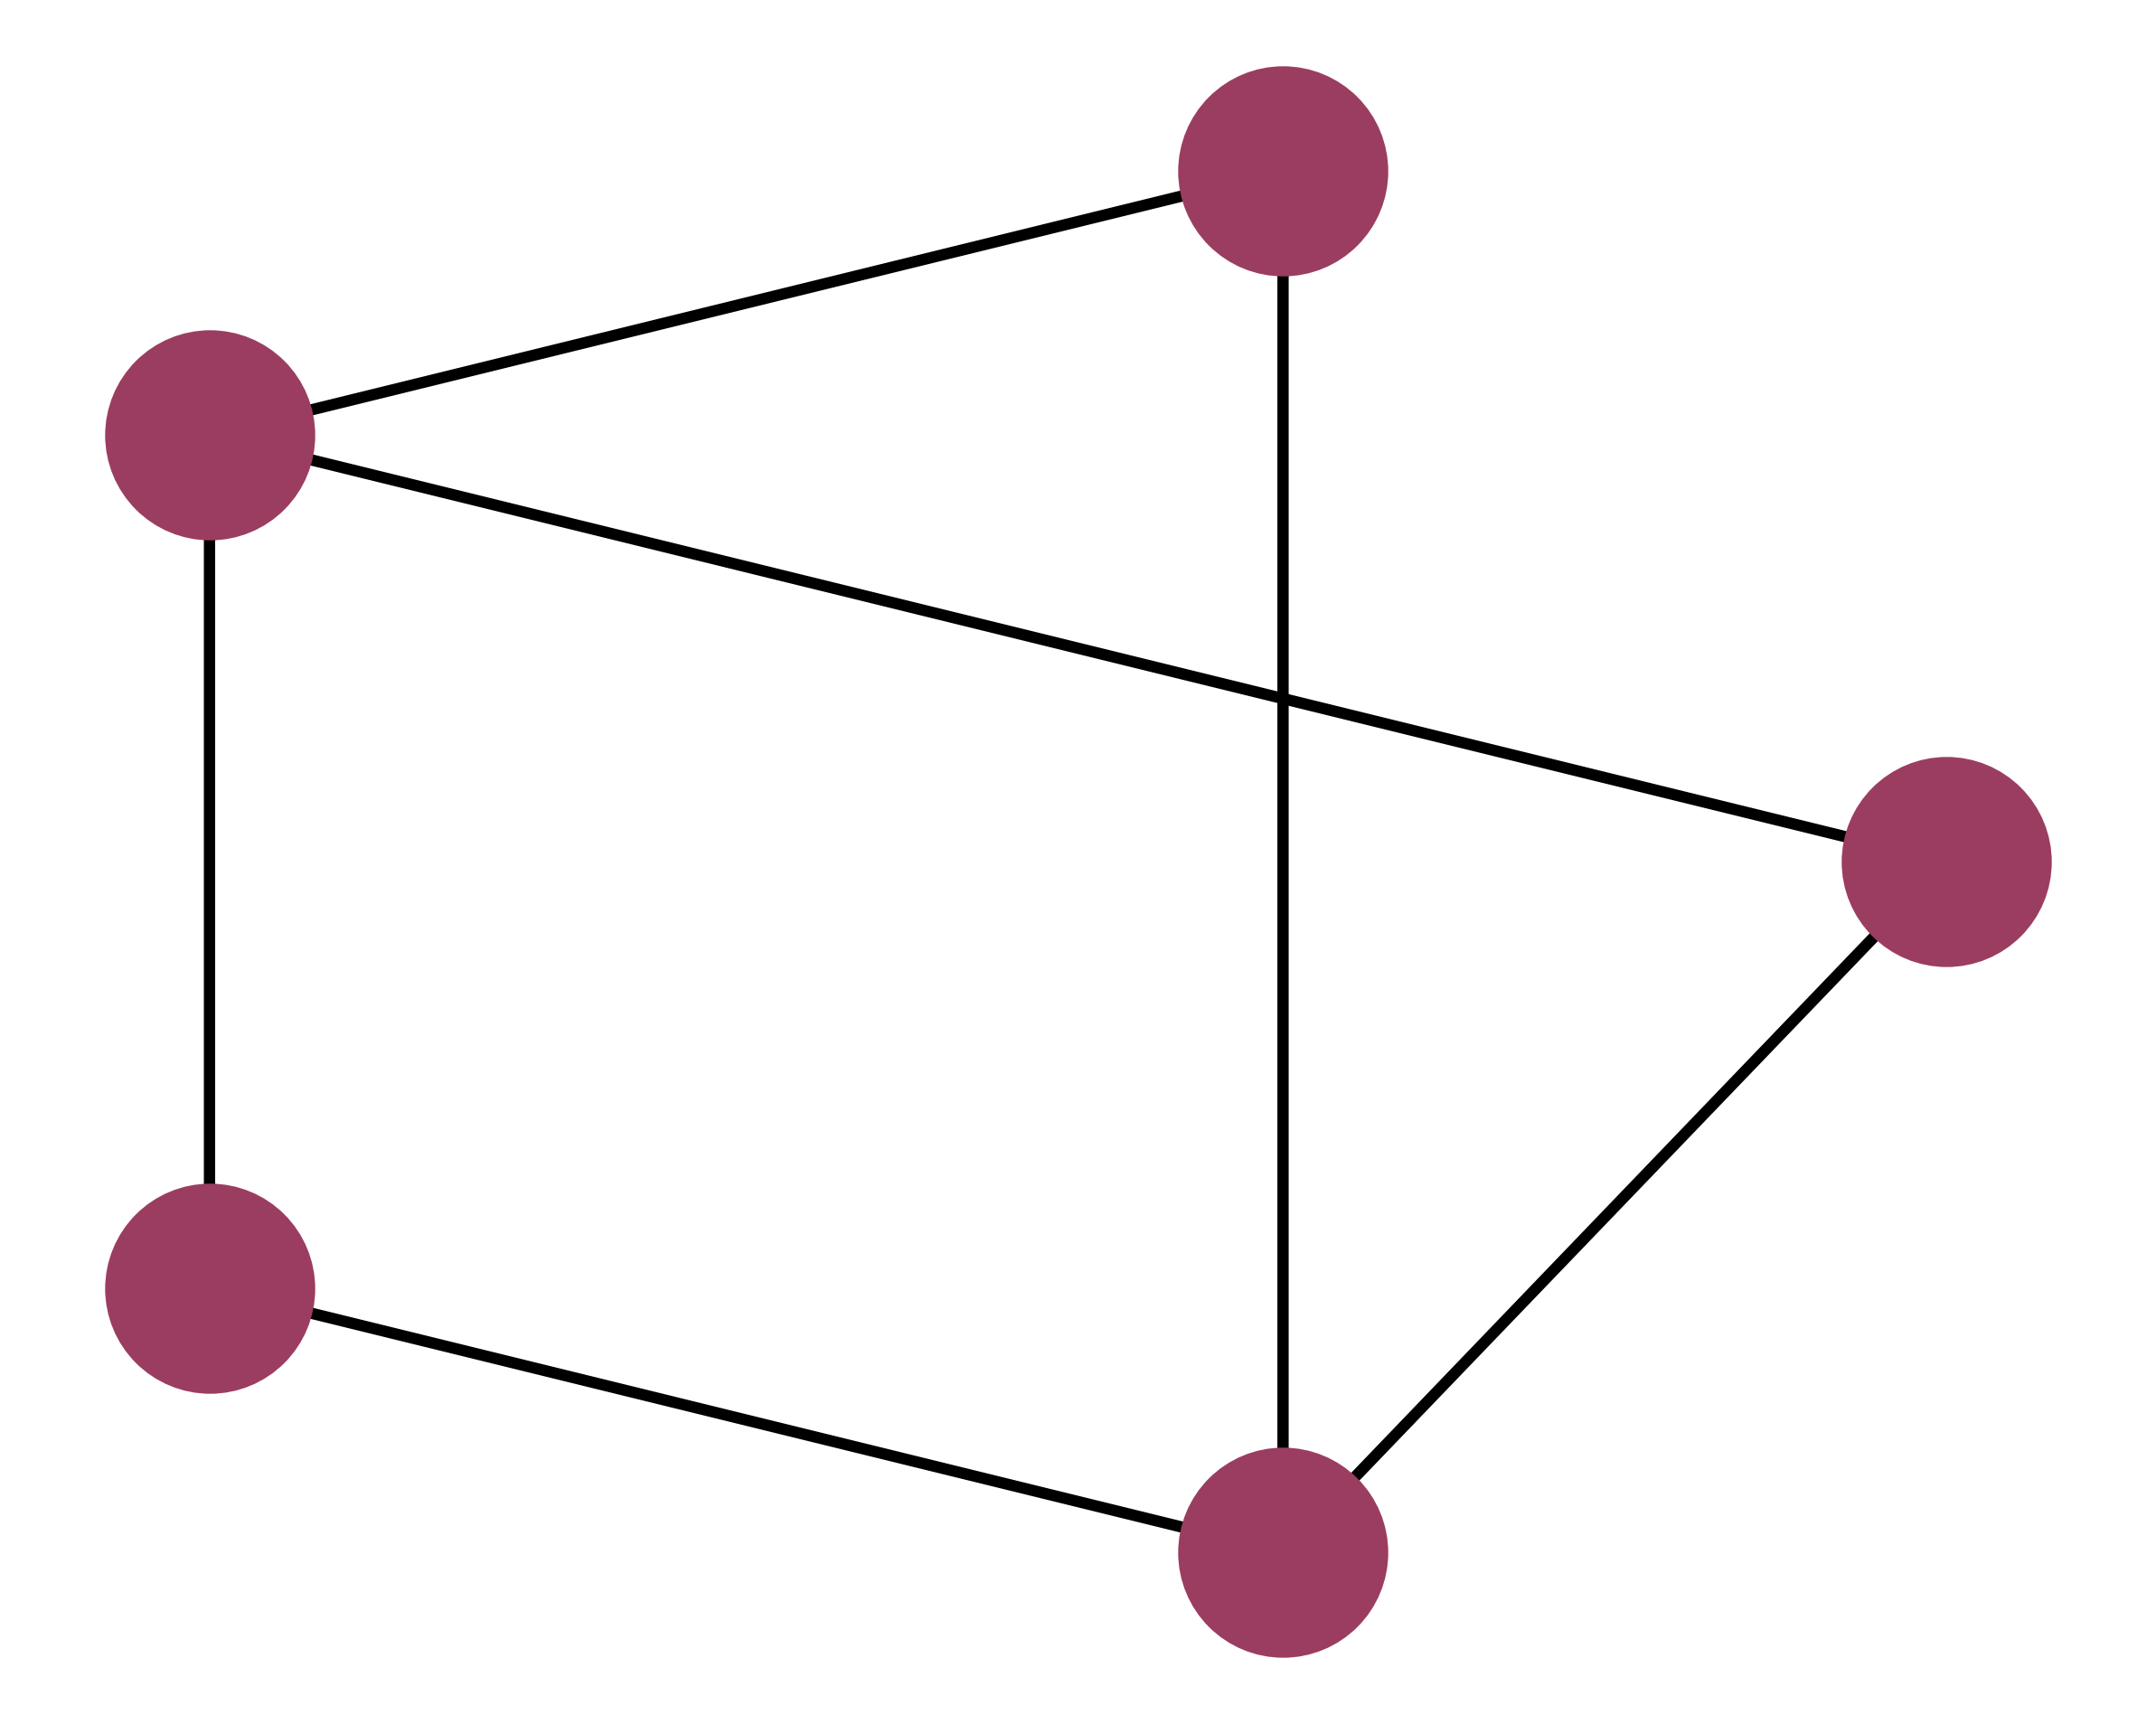

In [120]:
symmetric = np.maximum(G, G.transpose())
symmetric = nx.from_numpy_array(symmetric, create_using=nx.Graph)
draw_graph(symmetric, pos, 'Symmetric k-NN Graph')